In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [ ]:
import nmr_fkp.file_organizer as fo
from functions import fit_t2

[Meas(filename='scope_171.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(filename='scope_172.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(filename='scope_173.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(filename='scope_174.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(filename='scope_175.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(filename='scope_176.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(filename='scope_177.csv', path='nmr_fkp/data_day_three', meas=nan, comment=nan, useful=nan, F=nan, A=nan, B=nan, N=nan, tau=nan, P=nan), Meas(

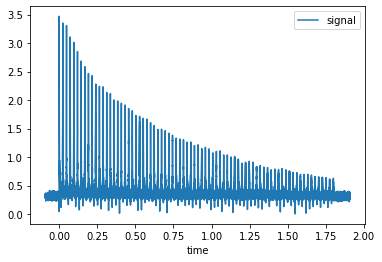

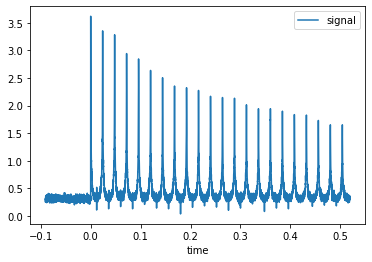

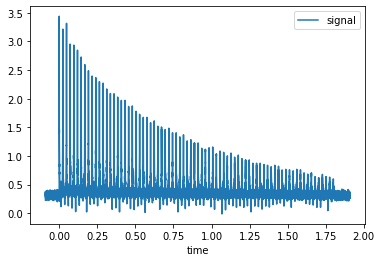

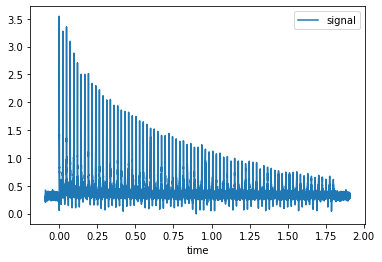

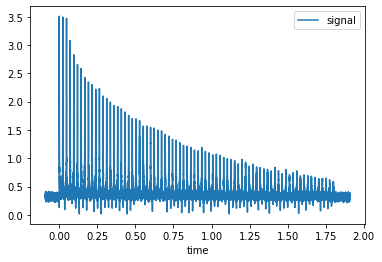

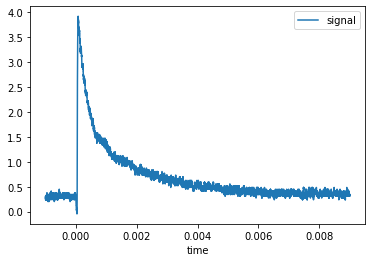

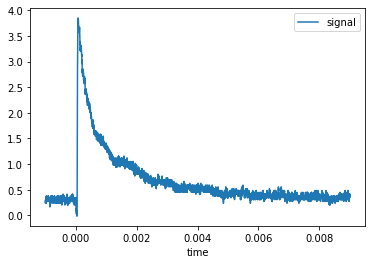

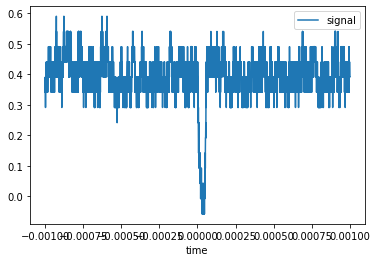

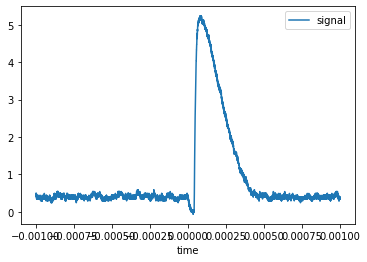

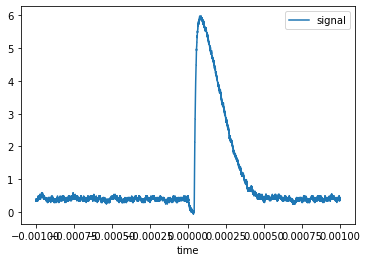

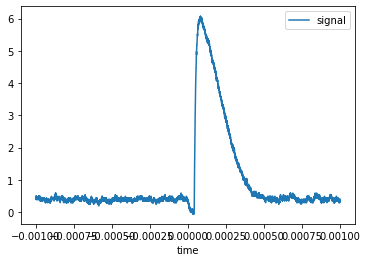

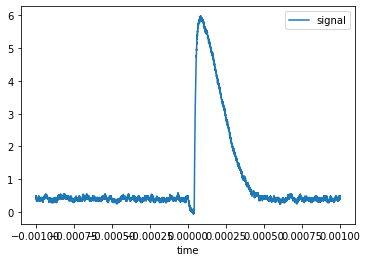

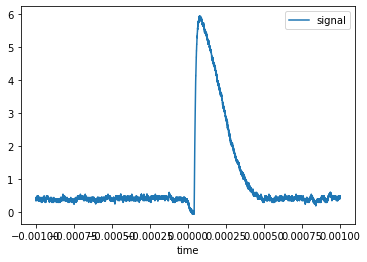

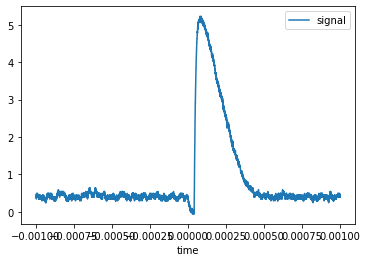

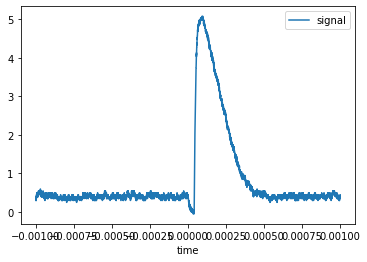

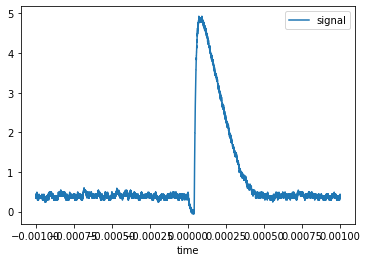

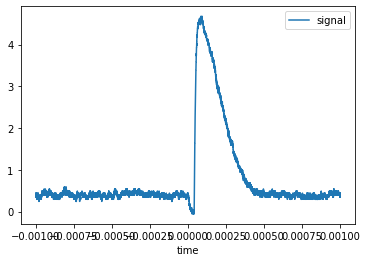

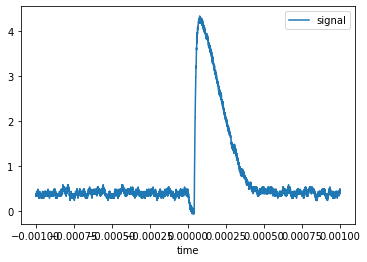

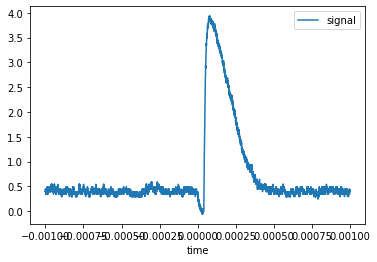

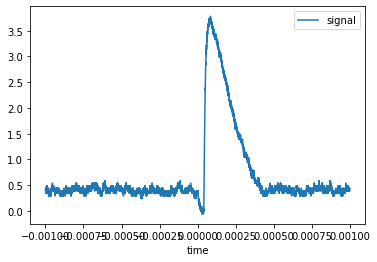

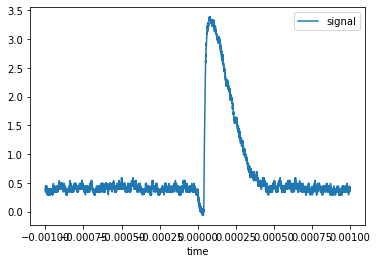

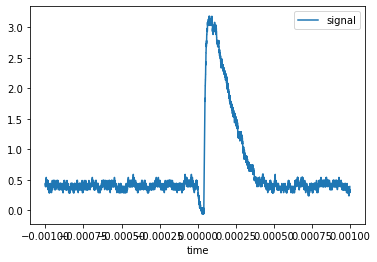

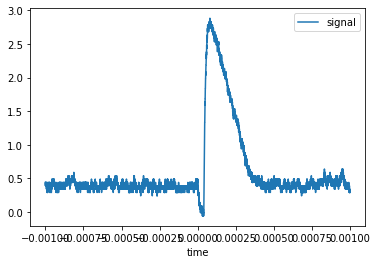

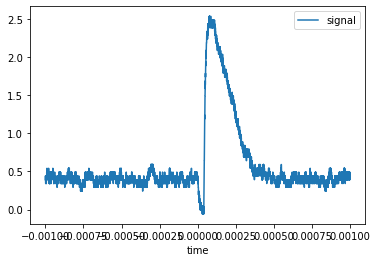

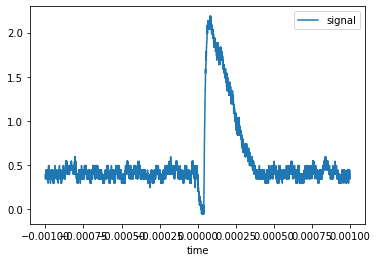

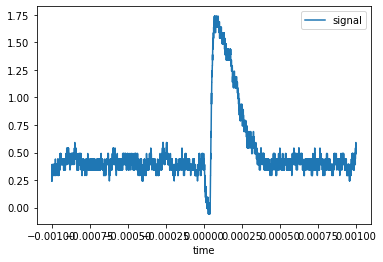

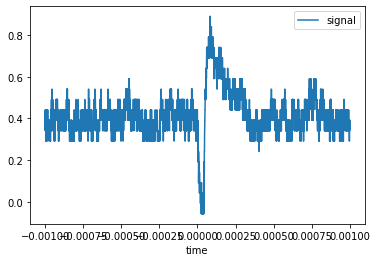

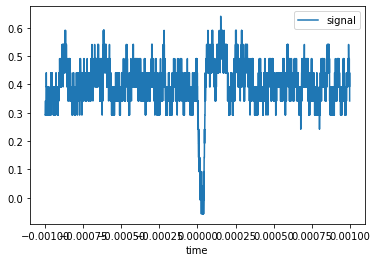

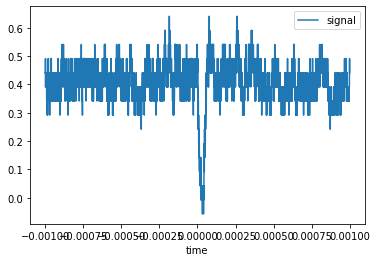

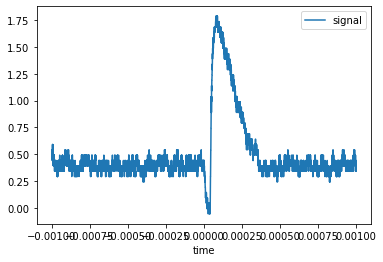

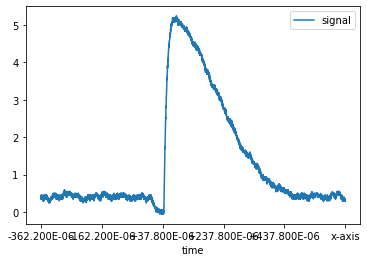

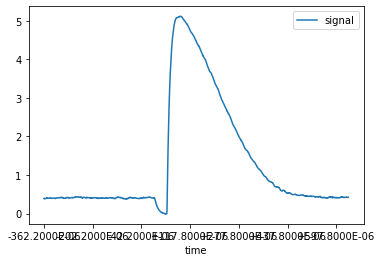

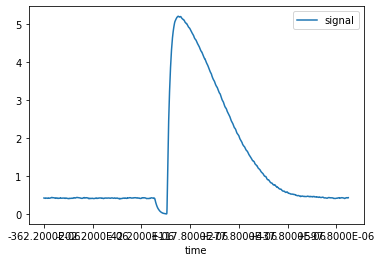

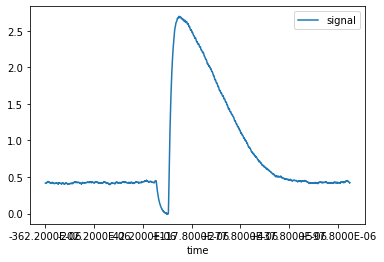

In [ ]:
PATH = 'nmr_fkp/data_day_three'
# fo.generate_file_list(PATH)

liste = fo.load_file_list(PATH)
print(liste)

for i in range(len(liste)):
    d = fo.load_sfile(liste[i].filename, path=PATH)

    d.plot(x='time', y='signal')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>